# 使用非监督学习(无标注)方式识别手写体数字

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist


Using TensorFlow backend.


## 1. 概述
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
图片识别相关技术如卷积神经网络(CNN)等已经比较普及，不同行业希望应用于实践来进行分类预测等以利用之前难以分析的海量数据。但在实际应用中，已经做好大规模标注的情况很少，而完全标注又需要大量的时间和人力资源，质量、成本难以控制。因此，利用不标注或仅少量标注的数据进行分析是当前的一个热点，也是切实可行的技术趋势。</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
本文介绍利用IBM DSX来进行非监督学习对手写体数字图片进行分类的技术 - 深度学习中非监督聚类分析(DEC)
</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 90%; COLOR: #191919; line-height: 1.5em;FONT-WEIGHT: bolder; font-style:oblique;">
&#42;&#42; 参考"Unsupervised Deep Embedding for Clustering Analysis" Junyuan Xie, Ross Girshick, Ali Farhadi
</p>

### 1.1 深度非监督聚类分析主要步骤介绍
<img src="../datasets/DEC.PNG"/>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
实现DEC包括了两个步骤：
</p>
<ol style="text-indent: 2em;">
    <li>使用自动编码器初始化参数</li>
    <li>调优参数 - 通过计算辅助目标分布最小化KL散度</li>
</ol>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
如上图所示，在第一个步骤中自动编码器又分为编码和解码两个过程，编码是把原图像使用深度网络抽取为特征，而解码则是把该特征还原为一幅图像数据。通过比较原图像和生成的图像可以对参数和特征调优，得到最符合的数值。然后，可以使用聚类算法，本文使用KMeans，对特征进行聚类分析，得到K(本文为10)个不同的聚簇。这是初始化参数的过程，这个过程中的编码参数和输出特征，以及聚类后的中心点都将作为第二个步骤的初始化参数。
</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
第一个步骤的第二部分是生成网络，也可以利用解码部分参数来生成手写体数字图片。
</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
第二个步骤是对聚类参数的调优过程，由于没有标注可供对照，因此使用了辅助目标分布函数，最小化KL散度来实现对聚类中心点和特征、参数的调整，提高准确率。
</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 90%; COLOR: #191919; line-height: 1.5em;FONT-WEIGHT: bolder; font-style:oblique;">
&#42;&#42; 本文的自动编码器部分也参考了变分自动编码器的方法，有兴趣可以自行搜索
</p>
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 90%; COLOR: #191919; line-height: 1.5em;FONT-WEIGHT: bolder; font-style:oblique;">
&#42;&#42; 另外，由于不是实际应用，仅仅是技术介绍并演示，本文没有单纯追求准确率，没有对整个层次架构和细节超参数进行优化，同时，迭代数也较少，不过从初始化特征聚类的69.2%，经过参数跳优最终也达到了大约78.7%的准确率。
</p>

## 2. 使用变分自动编码器(VAE)初始化参数
### 2.1 定义环境参数

In [2]:
# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
filters = 64
# decoder convolution kernel size
num_conv = 3
batch_size = 200
original_img_size = (img_rows, img_cols, img_chns)

# number of clustering centroid 
n_class = 10
# the encoder final features dimension
latent_dim = 10
# full connection layer dimension
intermediate_dim = 128
# Variational AutoEncoder sampling parameter
epsilon_std = 1.0
epochs = 5
# DEC parameter, default is 1.0
alpha = 1.0

### 2.2 使用深度卷积网络定义编码器部分

In [4]:
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

### 2.3 变分正态采样函数及处理层

In [5]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

### 2.4 使用反向网络定义解码器部分

In [6]:
# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * 14 * 14, activation='relu')

output_shape = (batch_size, 14, 14, filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
output_shape = (batch_size, 29, 29, filters)
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
# generate the original image
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)

### 2.5 VAE模型

In [7]:
# instantiate VAE model
vae = Model(x, x_decoded_mean_squash)

# Compute VAE loss
def vae_loss(x, x_decoded_mean_squash):
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(
        K.flatten(x),
        K.flatten(x_decoded_mean_squash))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)    
    return K.mean(xent_loss + kl_loss)
#vae.add_loss(vae_loss)

vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 28, 28, 1)     5                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 14, 14, 64)    320                                          
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 14, 14, 64)    36928                                        
___________________________________________________________________________________________

### 2.6 训练VAE模型

In [8]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

('x_train.shape:', (60000, 28, 28, 1))


In [9]:
import os
if os.path.isfile("vae_cnn_10.hdf5"):
    vae.load_weights("vae_cnn_10.hdf5")
else:
    vae.fit(x_train, x_train,
            shuffle=True,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, x_test))
    vae.save_weights("vae_cnn_10.hdf5")

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 234s - loss: 159.4911 - val_loss: 121.3828

## 3. 图形化理解生成网络并使用KMeans初始化
### 3.1 利用VAE编码网络得到手写体数字图片隐含特征

In [10]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)
# display a 3D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_train, batch_size=batch_size)

### 3.2 利用PCA对隐含特征降维图形化展现特征模式

In [11]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("vae_unsupervized") \
    .config("spark.some.config.option", "") \
    .getOrCreate()

In [49]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import PCA

m_data = []
for i in range(len(x_test_encoded)):
        m_data.append((Vectors.dense(x_test_encoded[i]),))

df_encoder = spark.createDataFrame(m_data, ["features"])
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model_pca = pca.fit(df_encoder)
centers = model.clusterCenters()
features = model_pca.transform(df_encoder).select("pcaFeatures")
features = np.array(features.rdd.map(lambda x: [x[0][0], x[0][1], x[0][2]]).collect(), dtype='float32')

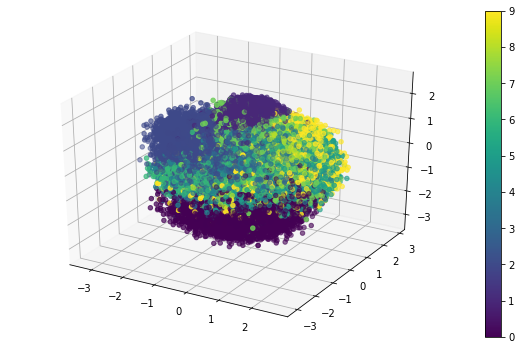

In [52]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.scatter(features[:, 2], features[:, 1], features[:, 0], c=y_train)

fig.colorbar(surf)

plt.show()

### 3.3 利用VAE的解码器生成手写体数字图片

In [53]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

演示使用demo=True，速度较快，展现三个手写体的图片

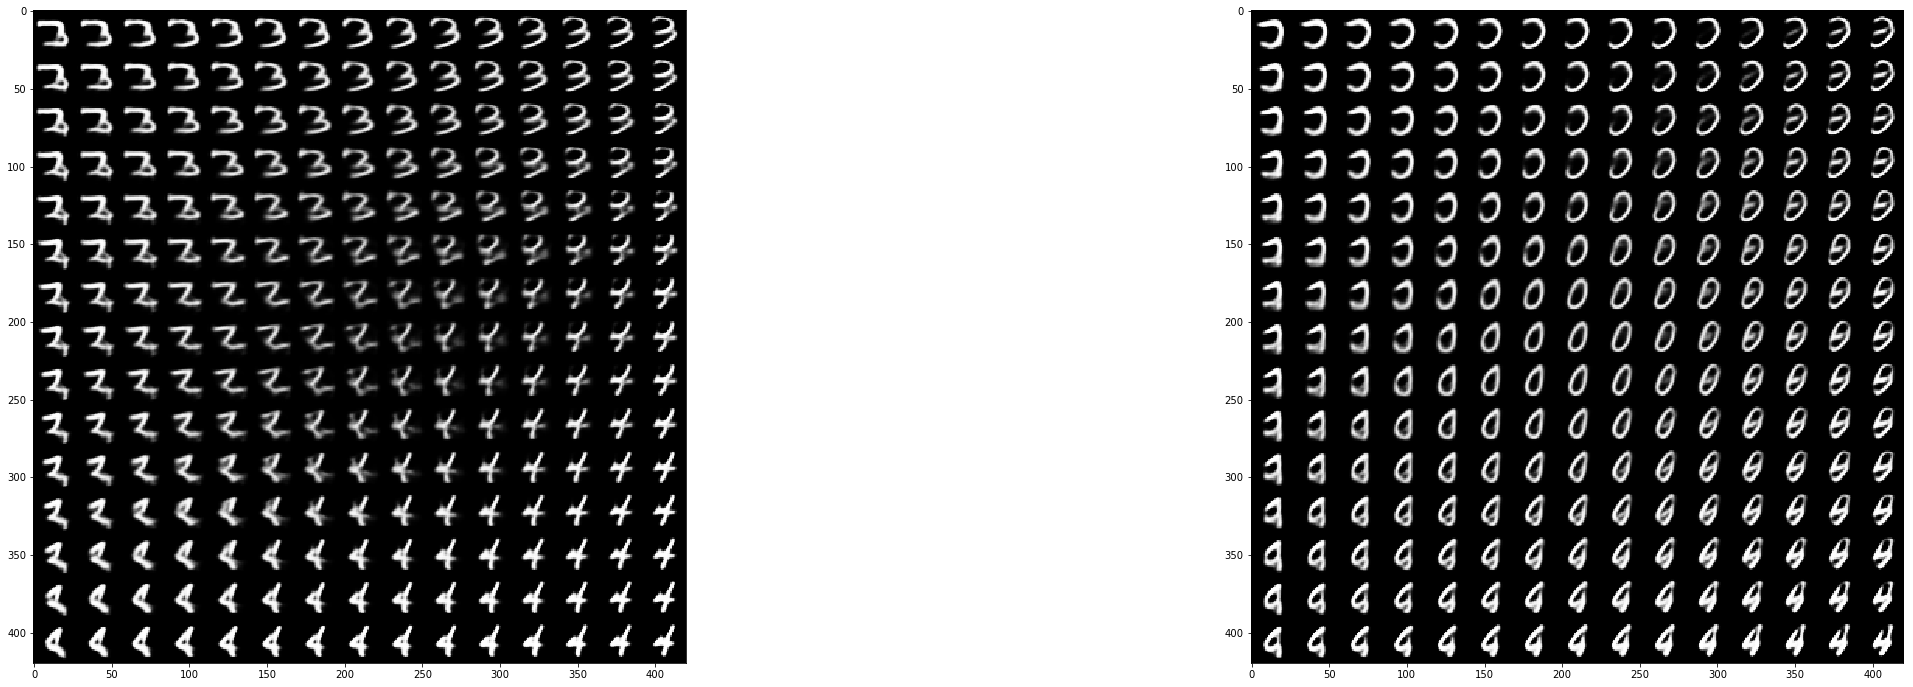

In [75]:
# display 5*3 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
grid_z = norm.ppf(np.linspace(0.05, 0.95, n))

demo = True

if demo:
    fig = plt.figure(figsize=(40, 12))

    ix = 1
    for zi in range(-1, 2, 2):
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                data = []
                for k in range(latent_dim/2-1):
                    data.append(yi)
                for k in range(latent_dim/2-1):
                    data.append(xi)
                for k in range(2):
                    data.append(zi)
                z_sample = np.array([data])
                z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
                x_decoded = generator.predict(z_sample, batch_size=batch_size)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
        ax = fig.add_subplot(1, 2, ix)
        ix = ix + 1
        ax.imshow(figure, cmap='Greys_r')
    plt.show()
else:
    fig = plt.figure(figsize=(60, 36))

    for ix, zi in enumerate(grid_z):
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([[xi, yi, zi]])
                z_sample = np.tile(z_sample, batch_size).reshape(batch_size, latent_dim)
                x_decoded = generator.predict(z_sample, batch_size=batch_size)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
        ax = fig.add_subplot(5, 5, ix + 1)
        ax.imshow(figure, cmap='Greys_r')
    plt.show()

### 3.4 利用KMeans对隐含特征进行聚类分析

In [12]:
from pyspark.ml.linalg import Vectors
from  pyspark.ml.clustering import KMeans

#m_data = []
#for i in range(len(x_test_encoded)):
#        m_data.append((Vectors.dense(x_test_encoded[i]),))

#df = spark.createDataFrame(m_data, ["features"])
kmeans = KMeans(k=10)
model = kmeans.fit(df_encoder)
centers = model.clusterCenters()
y_pred = model.transform(df).select("prediction")
y_pred = y_pred.rdd.map(lambda x: x[0]).collect()

### 3.5 得到聚类中心点作为初始化参数

In [ ]:
lst_centers = []
for i in range(len(centers)):
    lst_centers.append(centers[i].tolist())

## 4. 对参数调优提高聚类准确率
### 4.1 定义一个含有聚类中心点参数的新层
<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
该层的核心是计算目标分布。
</p>
$$
q_{ij} = \frac{(1+\|z_i - \mu_j\|^2/\alpha)^{-\frac{\alpha+1}{2}}}{\sum_{j'}{(1+\|z_i - \mu_{j'}\|^2/\alpha)^{-\frac{\alpha+1}{2}}}}
$$

In [14]:
from keras.engine.topology import Layer
class ClusteringLayer(Layer):
    def __init__(self, output_dim, input_dim=None, alpha=1.0, **kwargs):
        self.output_dim = output_dim
        self.input_dim = input_dim
        self.alpha = alpha

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(ClusteringLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='W', 
                                      shape = (self.output_dim, input_shape[1]),
                                      initializer='uniform',
                                      trainable=True)
        
        #self.W = K.variable(self.initial_weights)
        #self.trainable_weights = [self.W]
        super(ClusteringLayer, self).build(input_shape)

    def call(self, x, mask=None):
        q = 1.0/(1.0 + K.sqrt(K.sum(K.square(K.expand_dims(x, 1) - self.W), axis=2))**2 /self.alpha)
        q = q**((self.alpha+1.0)/2.0)
        q = K.transpose(K.transpose(q)/K.sum(q, axis=1))
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

### 4.2 利用编码器及新层构建DEC模型

In [15]:
from keras.models import Sequential
from keras.engine.topology import Layer, InputSpec
dec = Model(x, ClusteringLayer(n_class, name='clustering')(z))
dec.compile(loss='kullback_leibler_divergence', optimizer='adadelta')
# set the inititialized cluster_centers weights from KMeans
dec.get_layer('clustering').set_weights([np.array(lst_centers, dtype='float32')])
#dec.summary()

### 4.3 调优前的准确率

In [17]:
def cluster_acc(Y_pred, Y):
    from sklearn.utils.linear_assignment_ import linear_assignment
    D = max(max(Y_pred), max(Y))+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(len(Y_pred)):
        w[Y_pred[i], Y[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i,j] for i,j in ind])*1.0/len(Y_pred), w

In [18]:
update_interval = x_train.shape[0]/batch_size
train = True
iteration, index = 0, 0
acc = cluster_acc(y_train, y_pred)[0]
print('Accuracy '+str(np.round(acc, 5)))

Accuracy 0.69245


### 4.4 开始迭代调优

<p style="text-indent: 2em; font-family: 微软雅黑; FONT-SIZE: 100%; COLOR: #191919; line-height: 1.5em;">
使用辅助目标函数分布来作为调优的依据。
</p>
$$
p_{ij} = \frac{q_{ij}^2 \big/ f_j}{\sum_{f'}{q_{ij'}^2\big/f_{j'}}} ,\hspace{3em} 其中 f_j = \sum_i{q_{ij}}
$$

In [16]:
def compute_pij(q):
    weight = q**2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [19]:
if os.path.isfile("dec_weights_10.h5"):
    dec.load_weights("dec_weights_10.h5")
else:
    while train:
        if iteration % update_interval == 0:
            acc = cluster_acc(y_train, y_pred)[0]
            print('iteration ' + str(iteration) + ', Accuracy '+str(np.round(acc, 5)))

            q = dec.predict(x_train, verbose=0)
            p = compute_pij(q)
            y_pr = q.argmax(1)
            delta_label = ((y_pr == y_pred).sum().astype(np.float32) / y_pr.shape[0])
            y_pred = y_pr
            for i in range(len(encoder.layers)):
                encoder.layers[i].set_weights(dec.layers[i].get_weights())
        if (index+1)*batch_size > x_train.shape[0]:
            loss = dec.train_on_batch(x_train[index*batch_size::], p[index*batch_size::])
            index = 0
            #print('Loss %f' % loss)
        else:
            loss = dec.train_on_batch(x_train[index*batch_size:(index+1) * batch_size],
                        p[index*batch_size:(index+1) * batch_size])
            #print('Loss %f' % loss)
            index += 1

        if iteration == update_interval * 30:
            train = False
        iteration += 1
        dec.save_weights('dec_weights_10.h5')

iteration 0, Accuracy 0.69245
iteration 300, Accuracy 0.6902
iteration 600, Accuracy 0.70775
iteration 900, Accuracy 0.72588
iteration 1200, Accuracy 0.743
iteration 1500, Accuracy 0.75173
iteration 1800, Accuracy 0.75898
iteration 2100, Accuracy 0.76222
iteration 2400, Accuracy 0.76738
iteration 2700, Accuracy 0.7704
iteration 3000, Accuracy 0.77287
iteration 3300, Accuracy 0.7742
iteration 3600, Accuracy 0.7753
iteration 3900, Accuracy 0.77682
iteration 4200, Accuracy 0.77782
iteration 4500, Accuracy 0.7796
iteration 4800, Accuracy 0.78067
iteration 5100, Accuracy 0.78127
iteration 5400, Accuracy 0.78198
iteration 5700, Accuracy 0.78247
iteration 6000, Accuracy 0.78308
iteration 6300, Accuracy 0.78367
iteration 6600, Accuracy 0.7836
iteration 6900, Accuracy 0.78378
iteration 7200, Accuracy 0.78417
iteration 7500, Accuracy 0.78465
iteration 7800, Accuracy 0.78518
iteration 8100, Accuracy 0.78518
iteration 8400, Accuracy 0.78632
iteration 8700, Accuracy 0.78665
iteration 9000, Accuracy

### 4.5 查看预测值与实际值的分布矩阵及聚类标注对应表

In [20]:
r = cluster_acc(y_train, y_pred)
r[1]

array([[   1,   13, 5867,    7,    3,   18,    4,    0,    0,   10],
       [  28,    4,    1,  110,   16,  795,    1,   25, 5759,    3],
       [   0,    2,    7, 5863,   24,   14,   15,   16,    4,   13],
       [  13,    1,    1,   52,   49, 1167, 4757,   40,    1,   50],
       [3035,   12,   14,    6, 2661,   82,    3,   10,    5,   14],
       [   9,   14,    2,    2,   58, 3099, 2231,    0,    2,    4],
       [   1, 5672,   20,    1,    3,  177,   33,    0,    4,    7],
       [  71,    0,    2,  106,  558,    8,    7, 5498,    8,    7],
       [  44,    8,    7,   18,   19,   57,  810,    3,    7, 4878],
       [3182,    1,    9,    1, 2428,   60,  151,  102,    2,   13]])

In [21]:
from sklearn.utils.linear_assignment_ import linear_assignment
linear_assignment(r[1].max() - r[1])

array([[0, 2],
       [1, 8],
       [2, 3],
       [3, 6],
       [4, 4],
       [5, 5],
       [6, 1],
       [7, 7],
       [8, 9],
       [9, 0]])

## 5. 使用DEC模型图示化测试预测结果

('Actual digit is', 8)


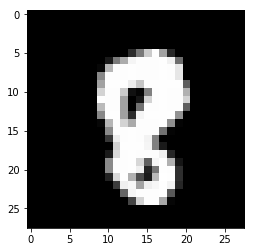

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def showIm(ix, x_test, y_test):
    image = (x_test[ix] * 255).reshape((28, 28)).astype("uint8")
    print("Actual digit is", y_test[ix])
    imgplot = plt.imshow(image)
    imgplot.set_cmap('gray')   

print "Predict value with DEC is, ", dec.predict(x_test[img].reshape(1, 28,28,1)).argmax(1)[0]
showIm(2050, x_test, y_test) 

1
('Actual digit is', 6)


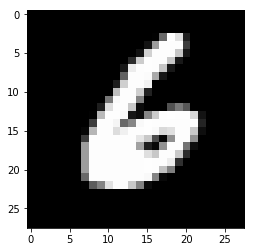

In [32]:
img = 9989
print "Predict value with DEC is, ", dec.predict(x_test[img].reshape(1, 28,28,1)).argmax(1)[0]
showIm(img, x_test, y_test) 

In [30]:
spark.stop()

1

## 作者

**李英伟 liyingw@cn.ibm.com ** 